In [1]:
import torch
import dill
import os.path as op
import numpy as np
import hnn_core
from hnn_core import simulate_dipole, Network, read_params, JoblibBackend
import matplotlib as mpl
import matplotlib.pyplot as plt
import sbi.utils as utils
from sbi.inference.base import infer
import multiprocessing
import datetime
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from scipy import interpolate


In [2]:
# posterior_file = open('../../data/ERP/12162020_150713/posterior_ERPNo_t10000_12162020_150713', 'rb')
# posterior_file = open('../../data/ERP/12152020_165639/posterior_ERPYes_t10000_12152020_165639', 'rb')
# posterior = dill.load(posterior_file)
# posterior_file.close()

posterior_file = open('../../data/ERP/prerun_simulations/ERP_Yes_round2_Yes_t1000000_02282021_193946/posterior_files_ANN_embedding.pkl', 'rb')
posterior_dict = dill.load(posterior_file)
posterior_yes = posterior_dict['posterior']
posterior_file.close()

posterior_file = open('../../data/ERP/prerun_simulations/ERP_Yes_round2_No_t1000000_03032021_173738/posterior_files_ANN_embedding.pkl', 'rb')
posterior_dict = dill.load(posterior_file)
posterior_no = posterior_dict['posterior']
posterior_file.close()

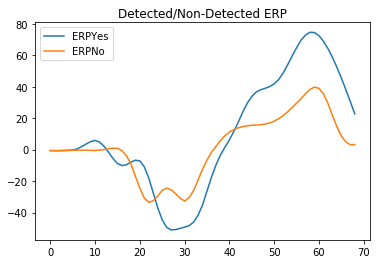

In [3]:
downsample = 100
ERPYes_dpl = np.loadtxt('../../data/ERP/ERPYes_dpl.txt', delimiter=',')[::downsample]
ERPNo_dpl = np.loadtxt('../../data/ERP/ERPNo_dpl.txt', delimiter=',')[::downsample]

plt.figure()
plt.plot(ERPYes_dpl)
plt.plot(ERPNo_dpl)
plt.legend(['ERPYes','ERPNo'])
plt.title('Detected/Non-Detected ERP')
plt.savefig('ERP_dipole.png')



In [4]:
prior_dict = {'gbar_L2Pyr_L2Pyr_ampa':(0, 0.01),
'gbar_L2Pyr_L2Pyr_nmda':(0, 0.01), 
'gbar_L2Basket_L2Pyr_gabaa':(0, 0.1),
'gbar_L2Basket_L2Pyr_gabab':(0, 0.1),
'gbar_L2Pyr_L5Pyr':(0, 0.01),
'gbar_L2Basket_L5Pyr':(0, 0.1),
'gbar_L5Pyr_L5Pyr_ampa':(0, 0.01),
'gbar_L5Pyr_L5Pyr_nmda':(0, 0.01),
'gbar_L5Basket_L5Pyr_gabaa':(0, 0.1),
'gbar_L5Basket_L5Pyr_gabab':(0, 0.1),
'gbar_L2Pyr_L2Basket':(0, 0.01),
'gbar_L2Basket_L2Basket':(0, 0.1),
'gbar_L2Pyr_L5Basket':(0, 0.01),
'gbar_L5Pyr_L5Basket':(0, 0.01),
'gbar_L5Basket_L5Basket':(0, 0.1)}

param_low = [float(item[0]) for key, item in prior_dict.items()]
param_high = [float(item[1]) for key, item in prior_dict.items()]
limits = [[param_low[idx], param_high[idx]] for idx in range(len(param_low))]
condition = [np.mean([param_low[idx], param_high[idx]]) for idx in range(len(limits))]
param_names = ['L2P_L2P_ampa',
'L2P_L2P_nmda', 
'L2B_L2P_gabaa',
'L2B_L2P_gabab',
'L2P_L5P',
'L2B_L5P',
'L5P_L5P_ampa',
'L5P_L5P_nmda',
'L5B_L5P_gabaa',
'L5B_L5P_gabab',
'L2P_L2B',
'L2B_L2B',
'L2P_L5B',
'L5P_L5B',
'L5B_L5B']



In [8]:
samples_Yes = posterior_yes.sample((10000,), x=ERPYes_dpl)
_ = utils.pairplot(samples_Yes, fig_size=(20,20), labels=param_names, limits=limits)
# plt.savefig('ERPNo_YesDpl_marginal.png')

NameError: name 'samples' is not defined

In [6]:
samples_No = posterior_no.sample((10000,), x=ERPNo_dpl)
_ = utils.pairplot(samples_No, fig_size=(20,20), labels=param_names, limits=limits)
# plt.savefig('ERPNo_NoDpl_marginal.png')

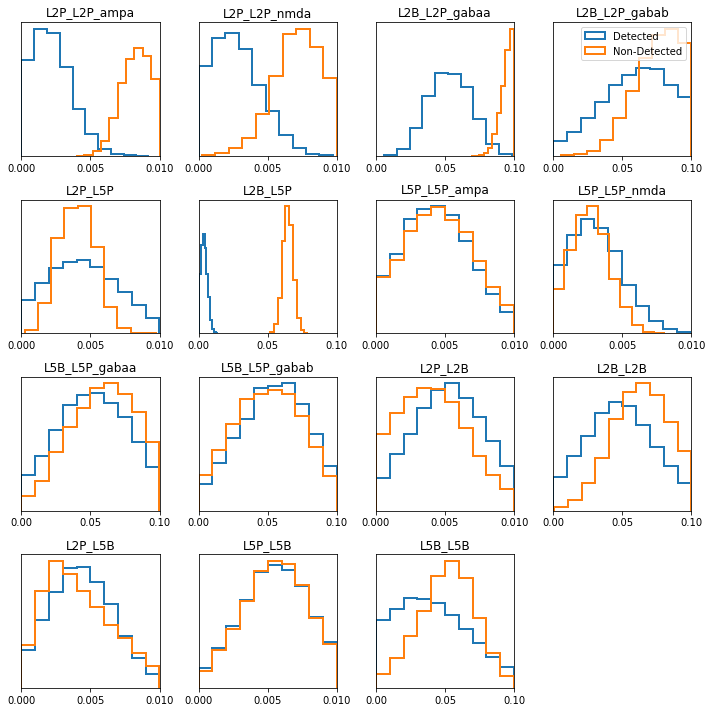

In [7]:
plt.figure(figsize=(10,10))
for p_idx, (_, limits) in enumerate(prior_dict.items()):
    plt.subplot(4,4,p_idx+1)
    plt.hist(samples_Yes[:,p_idx], histtype='step', LineWidth=2)
    plt.hist(samples_No[:,p_idx], histtype='step', LineWidth=2)
    if p_idx == 3:
        plt.legend(['Detected', 'Non-Detected'])
    plt.xlim(limits)
    plt.xticks(np.linspace(limits[0],limits[1],3))
    plt.yticks([])
    plt.tight_layout()
    plt.title(param_names[p_idx])

In [7]:
condition = posterior.sample((1,), x=ERPYes_dpl)

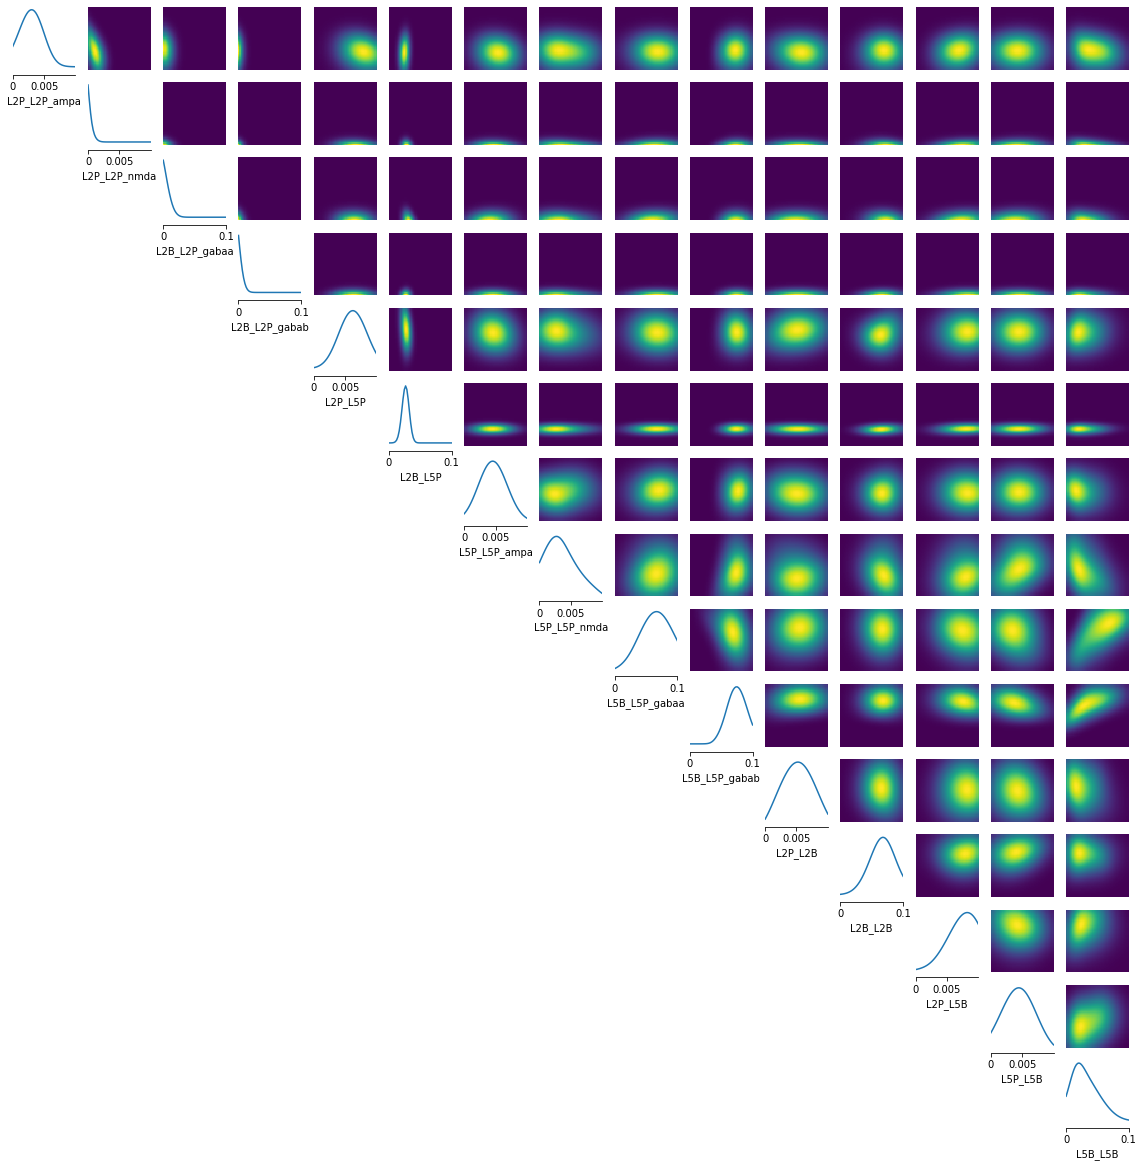

In [8]:
posterior.set_default_x(ERPYes_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(20,20), labels=param_names, limits=limits)
plt.savefig('ERPNo_YesDpl_conditional.png')

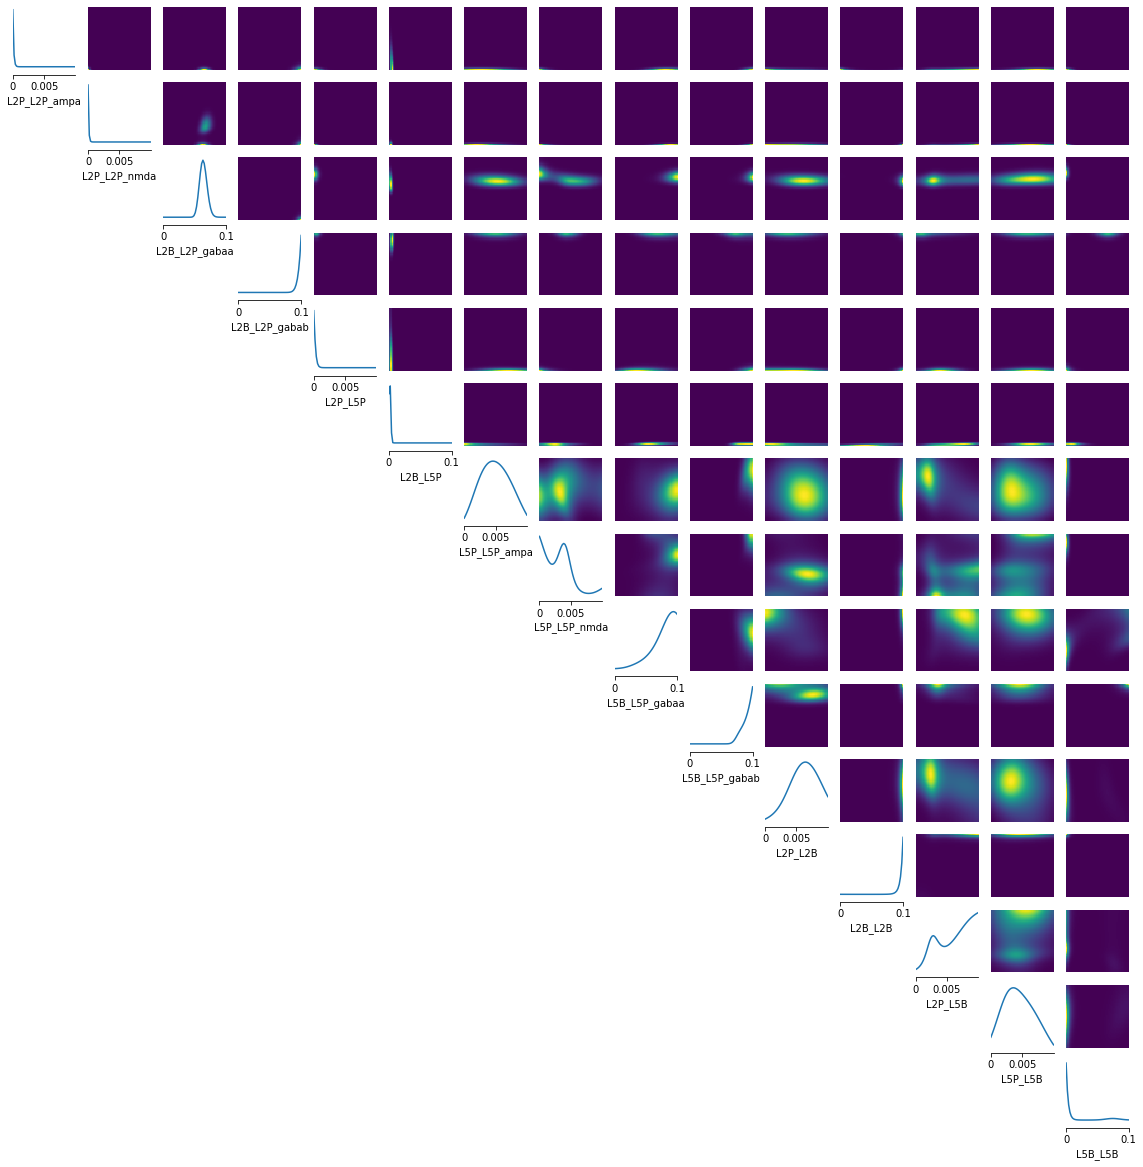

In [9]:
posterior.set_default_x(ERPNo_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(20,20), labels=param_names, limits=limits)
plt.savefig('ERPNo_NoDpl_conditional.png')